# Flower image classifier

## Project

Machine learning is getting incorporated more and more into everyday apps. Soon, anything with a camera will use image recognition which is based on deep learning models. The goal of the project is to build such a model for the purpose of recognizing flower species and use it in a simple application. The app will recognize flower types that are on the images.

## Import Resources

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
# The new version of dataset is only available in the tfds-nightly package
%pip --no-cache-dir install tfds-nightly --user
# need to restart the kernel after it is run for the first time

Note: you may need to restart the kernel to use updated packages.


## Dataset
The dataset contains images of 102 flower types
### Load

In [5]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# Load the dataset with TensorFlow Datasets
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)
    

# Create a training set, a validation set and a test set
training_set = dataset['train']
validation_set = dataset['validation']
test_set = dataset['test']

I0623 22:53:18.853711 140463029786432 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
oxford_flowers102
I0623 22:53:18.854490 140463029786432 dataset_info.py:358] Load dataset info from /home/adam/tensorflow_datasets/oxford_flowers102/2.1.1
I0623 22:53:18.859342 140463029786432 download_and_prepare.py:139] download_and_prepare for dataset oxford_flowers102/2.1.1...
I0623 22:53:18.859522 140463029786432 dataset_builder.py:287] Reusing dataset oxford_flowers102 (/home/adam/tensorflow_datasets/oxford_flowers102/2.1.1)
name: "oxford_flowers102"
description: "The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring\nin the United Kingdom. Each class consists of between 40 and 258 images. The images have\nlarge scale, pose and light variations. In addition, there are categories that have large\nvariations within the category and several very similar categories.\n\nThe dataset is divided into a training set, a validation set and a te

              low_value: 1.0
              high_value: 1.0
              sample_count: 102.0
            }
            buckets {
              low_value: 1.0
              high_value: 1.0
              sample_count: 102.0
            }
            buckets {
              low_value: 1.0
              high_value: 1.0
              sample_count: 102.0
            }
            buckets {
              low_value: 1.0
              high_value: 1.0
              sample_count: 102.0
            }
            buckets {
              low_value: 1.0
              high_value: 1.0
              sample_count: 102.0
            }
            buckets {
              low_value: 1.0
              high_value: 1.0
              sample_count: 102.0
            }
            buckets {
              low_value: 1.0
              high_value: 1.0
              sample_count: 102.0
            }
            type: QUANTILES
          }
          tot_num_values: 1020
        }
        unique: 1020
        top_value

### Explore

In [6]:
# Get the number of examples in each set from the dataset info
print("Number of examples:")
num_training_examples = dataset_info.splits['train'].num_examples
print("- training", num_training_examples)
num_validation_examples = dataset_info.splits['validation'].num_examples
print("- validation", num_validation_examples)
num_test_examples = dataset_info.splits['test'].num_examples
print("- test", num_test_examples)

# Get the number of classes in the dataset from the dataset info
num_classes = dataset_info.features['label'].num_classes
print("\nNumber of classes", num_classes)

Number of examples:
- training 1020
- validation 1020
- test 6149

Number of classes 102


In [7]:
# Print the shape and corresponding label of 3 images in the training set
print("Shape and label of the first 3 images:")
for image, label in training_set.take(3):
    print('\u2022 shape', image.shape, '\n\u0020 label', label.numpy())

Shape and label of the first 3 images:
• shape (500, 667, 3) 
  label 72
• shape (500, 666, 3) 
  label 84
• shape (670, 500, 3) 
  label 70


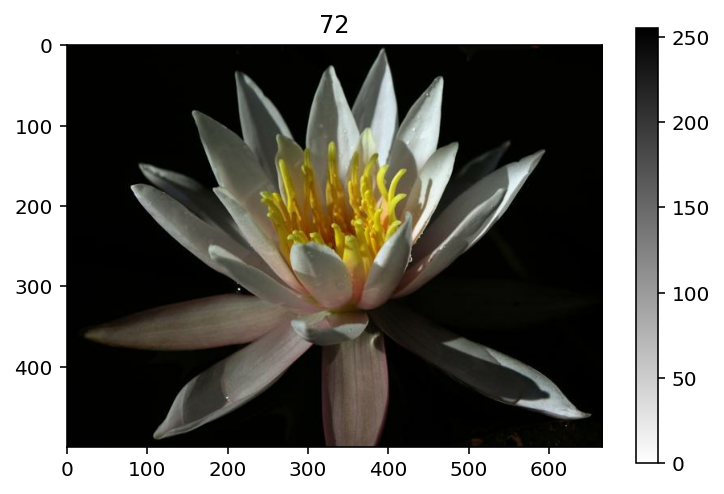

In [8]:
# Plot 1 image from the training set and its label
for image, label in training_set.take(1):
    plot_title = label.numpy()
    
    plt.imshow(image, cmap = plt.cm.binary)
    plt.title(plot_title)
    plt.colorbar()
    plt.show()

### Label Mapping
Load the flower names corresponding to the labels.

In [9]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

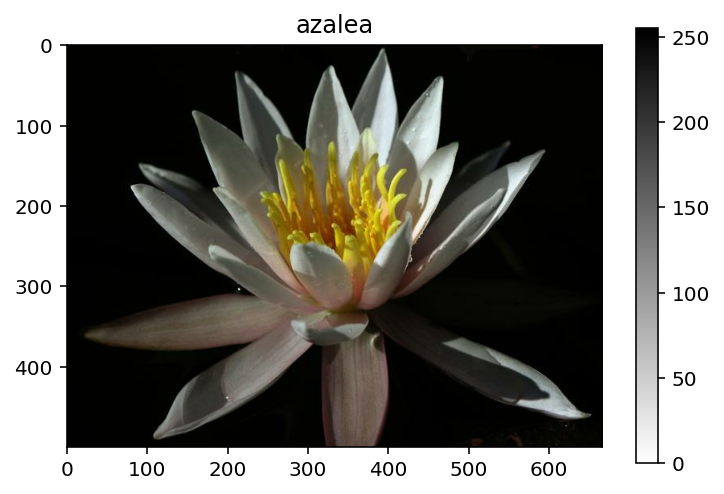

In [10]:
# Plot the image again, this time with corresponding class name
for image, label in training_set.take(1):
    plot_title = class_names[str(label.numpy())]

    plt.imshow(image, cmap = plt.cm.binary)
    plt.title(plot_title)
    plt.colorbar()
    plt.show()

## Create Pipeline

In [11]:
BATCH_SIZE = 64
IMG_SHAPE = 224

# Normalize color range of an image from 0-255 to 0-1
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

# Resize image
def resize(image, label):
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
    return image, label

# Apply the transformations and return a pipeline
def batchesOfImages(set):
    return set.cache() \
        .shuffle(num_training_examples // 4) \
        .map(resize) \
        .batch(BATCH_SIZE) \
        .map(normalize) \
        .prefetch(1)

# Create a pipeline for each set
training_batches = batchesOfImages(training_set)
validation_batches = batchesOfImages(validation_set)
test_batches = batchesOfImages(test_set)

# Build and Train the Classifier

The data is ready. Now is the time to build the model. Image classification is a challenging problem, for this reason the model will be built with the use of a pre-trained neural network. This approach is called transfer learning and it involves tuning the existing network that has been trained for a similar task.

This network is *MobileNet* and it comes from TensorFlow Hub repository. It has been trained on ImageNet, a massive dataset with over 1 million labeled images in 1000 categories. There is a lot of intelligence stored in this model which will be helpful in building the image classifier for flowers.

Because *MobileNet* is a network trained for a general image recognition, the best approach would be to tune it by just replacing the output layer and training it for classifying flowers. The fact that flowers dataset is small is another argument for keeping the weights of the pre-trained network constant.



### Load pre-trained network

It will be responsible for extracting the features of images.

In [12]:
# Load MobileNet
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

# Set its weights constant
feature_extractor.trainable = False

### Build the model
Add output layer with 102 output nodes.

In [13]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(102, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


### Train the model

In [14]:
# Train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 10

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/10
16/16 [==============================] - 21s 1s/step - loss: 4.4855 - accuracy: 0.0755 - val_loss: 3.5841 - val_accuracy: 0.2588
Epoch 2/10
16/16 [==============================] - 20s 1s/step - loss: 2.8017 - accuracy: 0.5206 - val_loss: 2.5933 - val_accuracy: 0.5461
Epoch 3/10
16/16 [==============================] - 19s 1s/step - loss: 1.7766 - accuracy: 0.7990 - val_loss: 1.9909 - val_accuracy: 0.6696
Epoch 4/10
16/16 [==============================] - 20s 1s/step - loss: 1.1543 - accuracy: 0.9069 - val_loss: 1.6353 - val_accuracy: 0.7284
Epoch 5/10
16/16 [==============================] - 19s 1s/step - loss: 0.8074 - accuracy: 0.9480 - val_loss: 1.4193 - val_accuracy: 0.7529
Epoch 6/10
16/16 [==============================] - 19s 1s/step - loss: 0.5925 - accuracy: 0.9696 - val_loss: 1.2770 - val_accuracy: 0.7686
Epoch 7/10
16/16 [==============================] - 20s 1s/step - loss: 0.4510 - accuracy: 0.9804 - val_loss: 1.1824 - val_accuracy: 0.7824
Epoch 8/10
16/16 [==

### Plot loss and accuracy

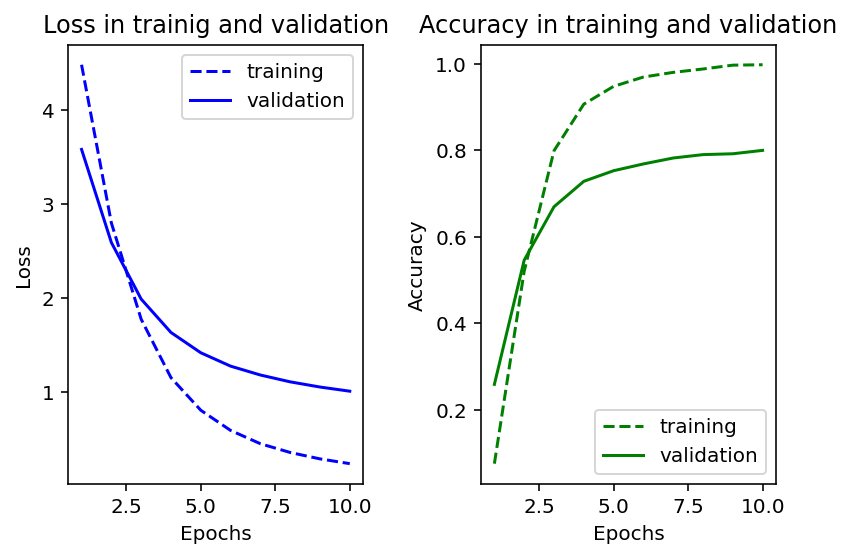

In [19]:
epochs = range(1, 11)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'b--', label = 'training')
plt.plot(epochs, history.history['val_loss'], 'b', label = 'validation')
plt.legend()
plt.title("Loss in trainig and validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'g--', label = 'training')
plt.plot(epochs, history.history['val_accuracy'], 'g', label = 'validation')
plt.legend()
plt.title("Accuracy in training and validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout() # to make plots not overlap
plt.show()

Training result is pretty good at about 80% validation accuracy. Although the distance between the curves grows significantly which indicates overfitting.

## Test the model
Real test on a previously unseen data, the testing set. It will give a good estimate of a model's performance in practice.

In [20]:
model.evaluate(test_batches)

97/97 [==============================] - 67s 689ms/step - loss: 1.1403 - accuracy: 0.7663


[1.1402945518493652, 0.7663034796714783]

Test results are not much different from the validation results. The model performs at about 77% accuracy.

## Save the model

In [24]:
# Save the model as a Keras model
save_filename = "image_classifier"
save_filepath = './{}.h5'.format(save_filename)

model.save(save_filepath)

## Load the model

In [26]:
model = tf.keras.models.load_model(
    save_filepath, 
    custom_objects = {'KerasLayer' : hub.KerasLayer} # model uses KerasLayer which is a part of hub.KerasLayer
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
